<a href="https://colab.research.google.com/github/sbbwoy/ESAA/blob/main/220624_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 04 합성곱 신경망(CNN)

### 4 위성 이미지 분류

#### 4-1 텐서플로 데이터셋 로드
- EuroSAT : 인공위성에서 지표면을 촬영한 이미지와 토지이용분류(Land Use and Land Coder) 값이 정리되어 있는 데이터셋
- 총 27000장의 위성 사진과 10개의 토지이용분류 값이 매칭되어 제공

In [3]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

EuroSAT 데이터셋 불러오기

- load 함수 사용

    - URL을 통해 데이터 다운로드
    - with_info : 메타 정보 포함 여부 지정
    - with_info=True : '(훈련 셋, 검증 셋), 메타 정보' 순으로 정리되어 반환
    - with_info=False : '(훈련 셋, 검증 셋)' 형태의 튜플로 반환
    - data_dir : 다운로드한 데이터셋 파일 저장 위치 지정
    - train 데이터만 제공

-> 80%는 훈련 셋(train_ds), 20%는 검증 셋(valid_ds)로 분할하여 저장

In [4]:
# EuroSAT 위성 사진 데이터셋 로드

DATA_DIR = "dataset/"   

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                        shuffle_files=True, 
                                        as_supervised=True,
                                        with_info=True, # 메타 정보
                                        data_dir=DATA_DIR) # 파일 저장 위치 지정
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to dataset/eurosat/rgb/2.0.0.incompleteHCD6NB/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


- 이미지는 (64, 64, 3) 형태

In [14]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

- info : 메타 정보 할당받은 변수 -> 데이터셋에 대한 기본 정보
- EuroSAT 데이터셋의 2가지 유형 중 JPEG 이미지로 인코딩한 RGB 데이터셋('eurosat/rgb')을 다운로드

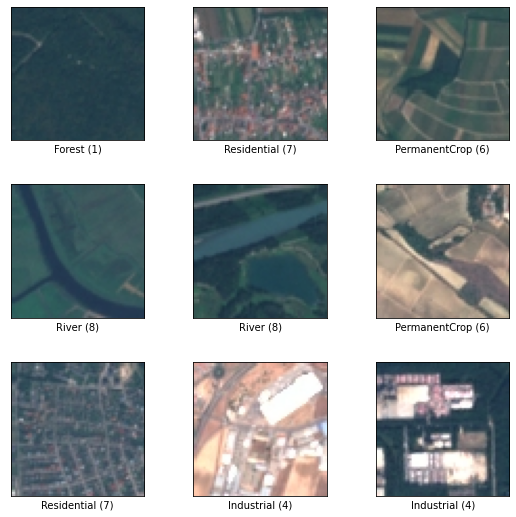

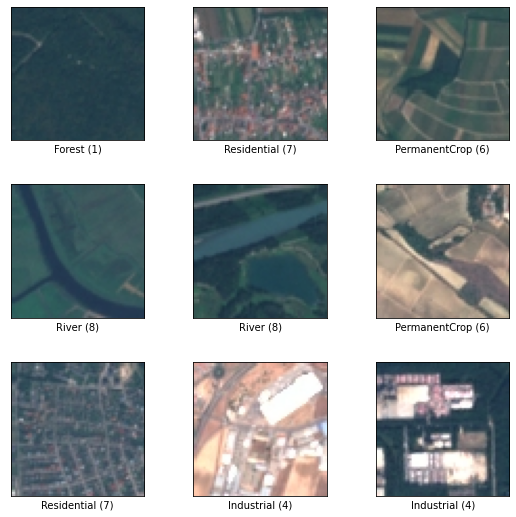

In [15]:
# 데이터 확인
tfds.show_examples(train_ds, info) # 샘플 이미지를 메타 정보인 분류 레이블과 함께 화면에 출력

,image,label
0,,9 (SeaLake)
1,,8 (River)
2,,9 (SeaLake)
3,,9 (SeaLake)
4,,9 (SeaLake)
5,,0 (AnnualCrop)
6,,2 (HerbaceousVegetation)
7,,0 (AnnualCrop)
8,,0 (AnnualCrop)
9,,2 (HerbaceousVegetation)

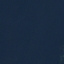
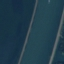
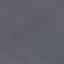
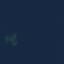
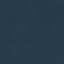
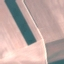
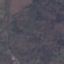
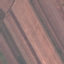
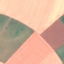
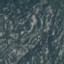

In [16]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info) # 샘플 이미지 10개를 화면에 표시

In [5]:
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


- 토지이용분류에 해당하는 정답 클래스는 10개

In [6]:
# 숫자 레이블을 활용해 문자열 메타 데이터로 변환
# 메타 데이터의 features 값 중 label에 해당하는 메타 정보에 int2str() 메소드 적용
print(info.features["label"].int2str(6))

PermanentCrop


- 클래스 6 : 영구 작물(PermanentCrop)

#### 4-2 데이터 전처리

`텐서플로 데이터셋 장점`

- 딥러닝 학습에 필요한 데이터셋을 쉽게 구할 수 있음
- 데이터 전처리 과정이 매우 쉬움 : 필요한 함수들을 제공, 텐서 연산을 효율적으로 처리할 수 있는 최적화 지원




`데이터 전처리`

1. 데이터 전처리 함수 preprocess_data 정의
    - 텐서플로 연산은 float32 숫자 값을 사용 -> cast 함수로 자료형을 float32로 변환
    - 입력 이미지는 0~255 사이의 픽셀 값 -> 255로 나눠서 정규화
    - map 함수를 이용해 사용자 정의 함수 매핑하여 텐서플로 데이터셋에 적용

2. num_parallel_calls 옵션을 AUTOTUNE으로 지정하여 텐서플로 병렬연산 처리 자동 최적화

    - 오토튠 미적용 시 데이터를 읽어서 매핑하고 훈련하는 과정을 순차적으로 처리하기 때문에 시간이 오래 걸림
    - 오토튠 적용 시 하드웨어 리소스를 병렬로 매핑하여 처리하기 때문에 같은 작업을 훨씬 짧은 시간에 처리 가능

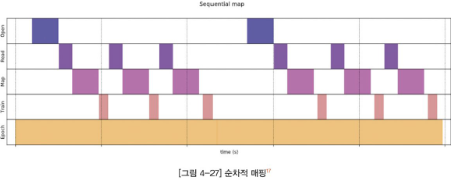

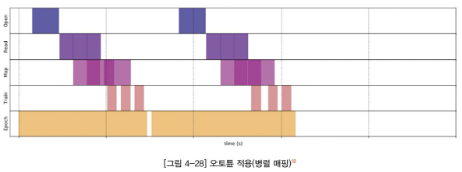

- 정규화 변환을 마친 데이터셋에 shuffle() 메소드 적용하여 순서 랜덤하게 섞기
    - 모델의 일반화된 성능 향상 위해 모델의 가중치를 학습하는데 사용되는 훈련 데이터셋에서 미니 배치를 생성할 때 입력 순서에 무작위성 부여
        - buffer_size 파라미터
            - 데이터셋의 크기가 작은 경우 전체 데이터셋의 개수만큼 지정해주는 것이 무작위성을 확보하는 데 유리
            - 데이터셋 개수가 많거나 이미지 파일의 크기가 커서 시스템상의 메모리에 전부 올릴 수 없는 경우 1000으로 지정
    - 처음 1000개의 데이터를 가져와서 섞고, 그 중 64개의 데이터를 랜덤하게 선택해서 하나의 배치 구성
    - 평가 목적에 활용되는 검증 데이터셋은 순서가 큰 의미가 없기 때문에 shuffle() 함수 사용할 필요 없음
- prefetch() 메소드를 이용해 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와서 미리 전처리를 하도록 시스템을 조율
    - 병렬 처리를 통해 모델 훈련 시간 단축

In [7]:
# 데이터 전처리 파이프라인 
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

### 4-3 모델 훈련 및 검증

In [8]:
def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        # 유닛 1
        tf.keras.layers.BatchNormalization(), # 배치 정규화
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'), # 합성곱
        tf.keras.layers.MaxPooling2D((2, 2)), # 풀링
        # 유닛 2
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        # Dense 레이어와 Dropout으로 구성된 최종 분류기
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

model = build_model()

In [21]:
# 모델 컴파일
# 예측 클래스가 10개인 다중 분류 문제에 적합한 손실함수와 평가지표 설정
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=50)

Epoch 1/50
338/338 [==============================] - 183s 536ms/step - loss: 1.6212 - accuracy: 0.4373 - val_loss: 1.7279 - val_accuracy: 0.4180
Epoch 2/50
338/338 [==============================] - 162s 478ms/step - loss: 1.2335 - accuracy: 0.5577 - val_loss: 0.9411 - val_accuracy: 0.6689
Epoch 3/50
338/338 [==============================] - 162s 479ms/step - loss: 1.0315 - accuracy: 0.6270 - val_loss: 0.7688 - val_accuracy: 0.7530
Epoch 4/50
338/338 [==============================] - 160s 473ms/step - loss: 0.9124 - accuracy: 0.6733 - val_loss: 0.7352 - val_accuracy: 0.7637
Epoch 5/50
338/338 [==============================] - 162s 479ms/step - loss: 0.8337 - accuracy: 0.7009 - val_loss: 0.7079 - val_accuracy: 0.7539
Epoch 6/50
338/338 [==============================] - 162s 480ms/step - loss: 0.7495 - accuracy: 0.7382 - val_loss: 0.5482 - val_accuracy: 0.8187
Epoch 7/50
338/338 [==============================] - 160s 473ms/step - loss: 0.6785 - accuracy: 0.7703 - val_loss: 0.5066 -

In [9]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

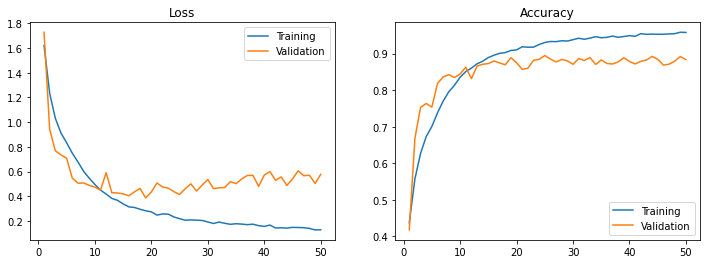

In [23]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history, 50)

- 10 epoch까지는 빠른 속도로 훈련이 진행되면서 손실함수가 급격하게 감소

- 그 이후로는 검증 셋에 대한 손실함수가 더 이상 줄어들지 않으면서 과대적합되는 경향 나타남

###4-4 데이터 증강(Data Augmentation)

- 데이터 증강 : 이미지 데이터에 여러 가지 변형을 주어서 훈련 데이터의 다양성을 확보하는 방식, 모델이 새로운 데이터에 대한 예측력을 강화하도록 함
    - 이미지 분류 문제에서 과대적합 해소
    - 모델의 일반화된 Robust한 성능을 확보

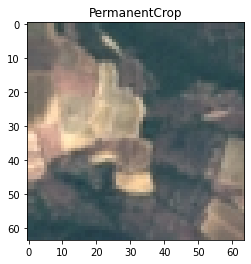

In [24]:
# 샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [25]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

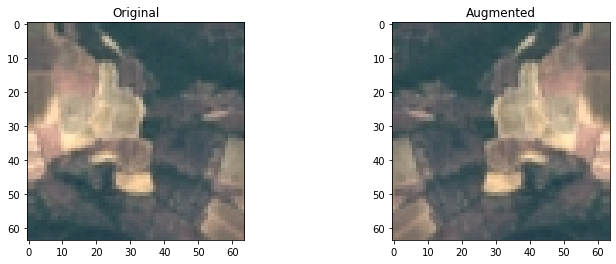

In [26]:
# 좌우 뒤집기 
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

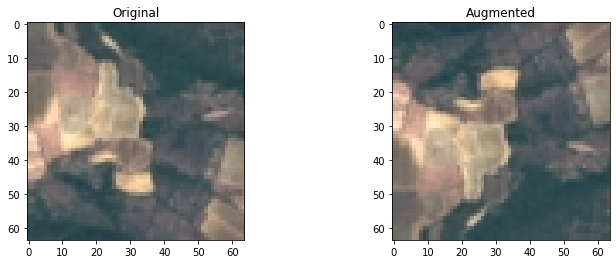

In [27]:
# 상하 뒤집기 
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

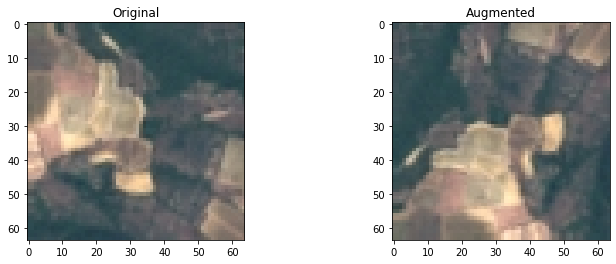

In [28]:
# 회전 
rotate90 = tf.image.rot90(image) # 이미지를 반시계 방향으로 90도 회전
plot_augmentation(image, rotate90)

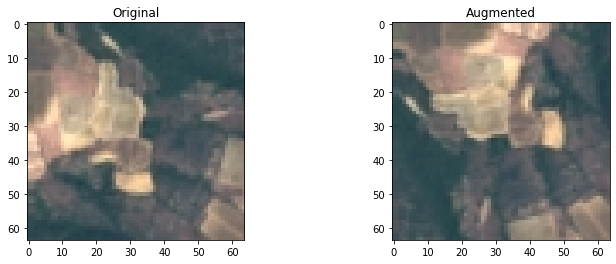

In [29]:
# transpose 
transpose = tf.image.transpose(image) # 이미지 텐서 행렬의 행과 열 위치 바꿔줌
plot_augmentation(image, transpose)

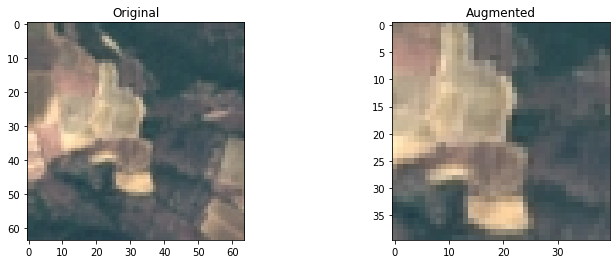

In [30]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6) # 이미지의 중심에서 일정 부분을 잘라냄
plot_augmentation(image, crop1)

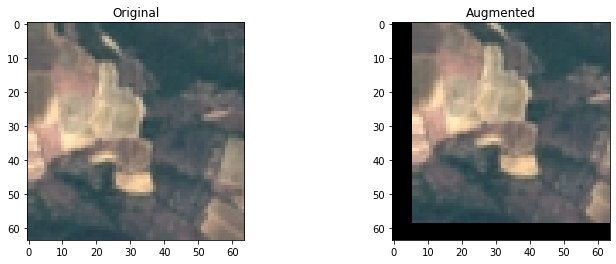

In [31]:
# 이미지 자르기 2 
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3]) # 이미지를 원본 크기와 같게 자름
plot_augmentation(image, crop2)

- 원본 이미지가 상하좌우 랜덤한 방향으로 이동

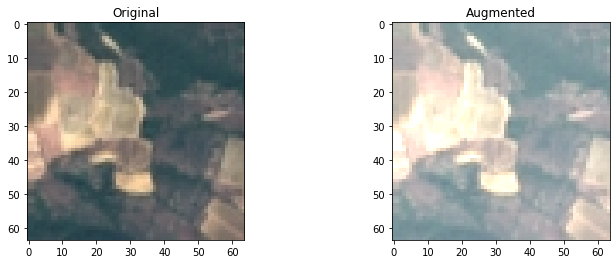

In [32]:
# 이미지 밝기 
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

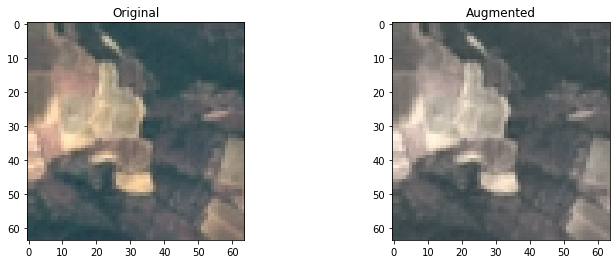

In [33]:
# 이미지 채도 
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

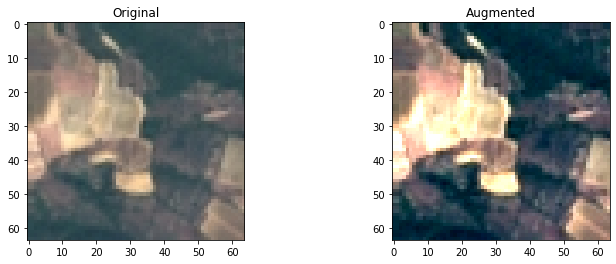

In [34]:
# 이미지 대비  
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

### 데이터 증강 및 전처리 수행

In [10]:
# 이미지 증강 전처리
def data_augmentation(image, label):
    # 이미지 증강 효과에 랜덤성을 부여하기 위해 tf.image 모듈에서 지원하는 함수 중 'random_'으로 시작하는 함수 적용
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전    
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화 
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

# map 함수로 원본 데이터셋에 적용
train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

# shuffle 함수와 batch 함수 등을 적용하여 미니 배치 생성
train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [11]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, 
                            validation_data=valid_aug, 
                            epochs=50)

Epoch 1/50
338/338 [==============================] - 23s 29ms/step - loss: 1.8662 - accuracy: 0.3072 - val_loss: 1.6906 - val_accuracy: 0.3848
Epoch 2/50
338/338 [==============================] - 9s 27ms/step - loss: 1.5602 - accuracy: 0.3987 - val_loss: 1.3515 - val_accuracy: 0.4774
Epoch 3/50
338/338 [==============================] - 9s 25ms/step - loss: 1.4248 - accuracy: 0.4525 - val_loss: 1.1858 - val_accuracy: 0.5743
Epoch 4/50
338/338 [==============================] - 9s 25ms/step - loss: 1.3492 - accuracy: 0.4873 - val_loss: 1.1477 - val_accuracy: 0.6050
Epoch 5/50
338/338 [==============================] - 9s 26ms/step - loss: 1.2785 - accuracy: 0.5193 - val_loss: 1.1256 - val_accuracy: 0.5861
Epoch 6/50
338/338 [==============================] - 9s 26ms/step - loss: 1.2202 - accuracy: 0.5430 - val_loss: 0.9892 - val_accuracy: 0.6487
Epoch 7/50
338/338 [==============================] - 10s 30ms/step - loss: 1.1936 - accuracy: 0.5656 - val_loss: 0.9621 - val_accuracy: 0.66

- 데이터 증강 전후 모델의 성능 자체는 큰 차이 없음

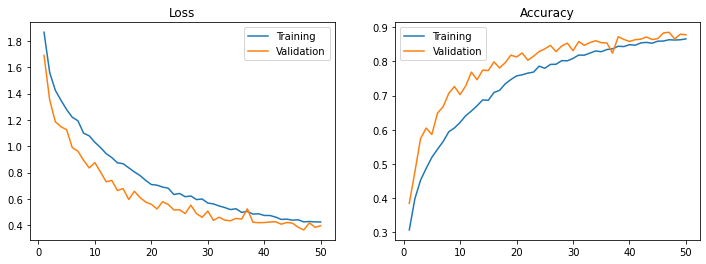

In [12]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(aug_history, 50)

- 훈련 셋과 검증 셋에 대한 손실함수는 50 epoch 동안 계속 감소

- 정확도는 조금씩 우상향하며 개선

-> 과대적합 문제가 상당히 해소됨

### 4-5 ResNet 사전 학습 모델


- ResNet 모델 : 이미지넷 경진 대회에서 우승한 모델, 152개의 깊은 층을 쌓는 방식으로 모델의 예측력을 높이면서도 skip connection 기법을 사용해 경사소실 문제 해결
- 전이 학습 이용 : 사전에 방대한 이미지로 훈련을 받은 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델의 끝단에 위치하는 Top 층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가하는 방식으로 모델 구성

94683136/94668760 [==============================] - 1s 0us/step


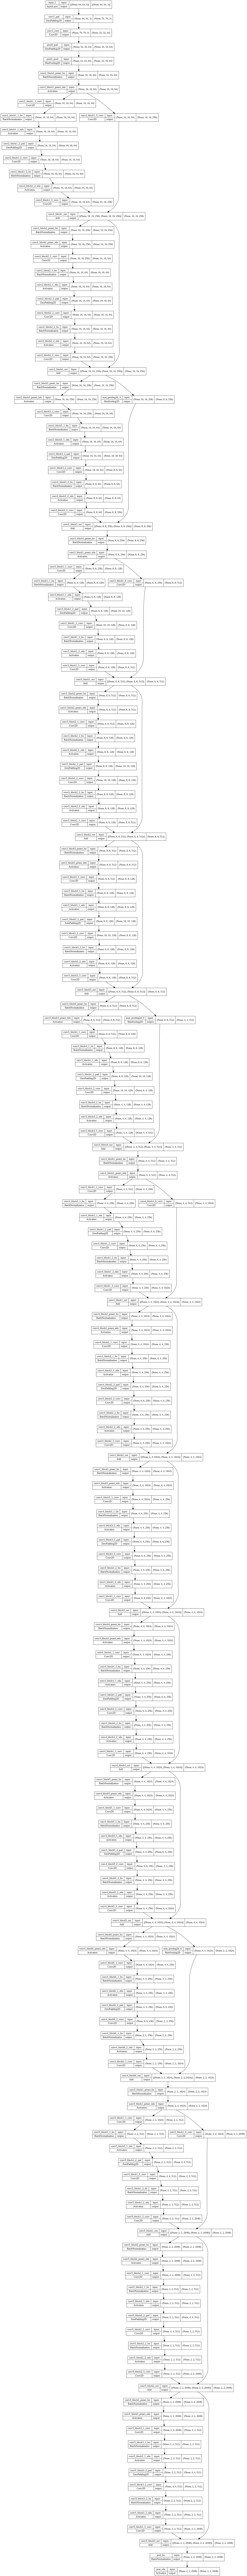

In [13]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False, # 기존 ResNet 모델의 Top 층을 제거 -> 최종 분류기를 대체하여 추가
                              weights='imagenet',
                              input_shape=[64, 64, 3]) # 위성 이미지의 크기 지정 -> 케라스에서 이미지 크기를 지정한 크기로 맞춰서 줄여줌

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from keras.utils.vis_utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='/content/resnet50.png')


In [14]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

    model = tf.keras.Sequential([

        # Pre-trained Base 
        pre_trained_base,
        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),     
        # 10개 클래스에 대한 다중 분류 -> Dense 레이어의 노드 개수 NUM_CLASSES와 softmax 활성화 함수 지정         
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'), # NUM_CLASSES : 위성 이미지의 클래스 레이블 개수(10)
    ])

    return model

# 모델 구조
tc_model = build_trainsfer_classifier()    
tc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)               

- 23,564,800개의 파라미터는 훈련 불가능

- Top 층에 추가한 Dense 레이어들의 파라미터만 가중치가 업데이트됨

In [15]:
# 모델 컴파일
tc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# 모델 훈련
tc_history = tc_model.fit(train_aug, 
                          validation_data=valid_aug, 
                          epochs=50)

Epoch 1/50
338/338 [==============================] - 18s 42ms/step - loss: 1.0462 - accuracy: 0.6632 - val_loss: 0.5930 - val_accuracy: 0.8091
Epoch 2/50
338/338 [==============================] - 12s 36ms/step - loss: 0.7347 - accuracy: 0.7648 - val_loss: 0.5239 - val_accuracy: 0.8289
Epoch 3/50
338/338 [==============================] - 13s 36ms/step - loss: 0.6447 - accuracy: 0.7977 - val_loss: 0.4971 - val_accuracy: 0.8391
Epoch 4/50
338/338 [==============================] - 12s 36ms/step - loss: 0.5989 - accuracy: 0.8076 - val_loss: 0.4689 - val_accuracy: 0.8430
Epoch 5/50
338/338 [==============================] - 12s 34ms/step - loss: 0.5713 - accuracy: 0.8145 - val_loss: 0.4608 - val_accuracy: 0.8444
Epoch 6/50
338/338 [==============================] - 12s 35ms/step - loss: 0.5571 - accuracy: 0.8200 - val_loss: 0.4581 - val_accuracy: 0.8502
Epoch 7/50
338/338 [==============================] - 12s 35ms/step - loss: 0.5200 - accuracy: 0.8295 - val_loss: 0.4394 - val_accuracy:

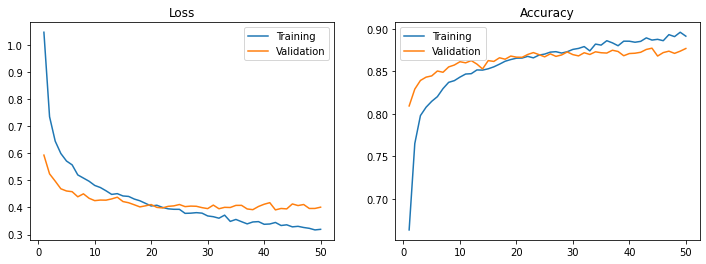

In [16]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(tc_history, 50)

- 훈련 초기부터 검증 셋에 대한 정확도가 80% 넘음 -> 사전 학습 모델인 ResNet 모델의 가중치를 그대로 사용

-> 새로운 데이터인 위성 이미지가 입력되어도 이미지로부터 피처를 빠르게 추출